In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Points before fin deletion: (100822, 3)
Points after fin deletion: (98532, 3)


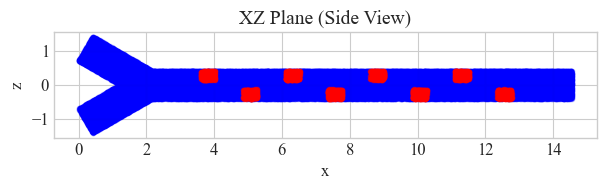

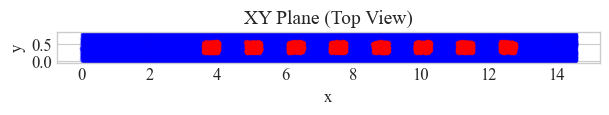

In [16]:
# -----------------------------
# Geometry Parameters (scaled)
# -----------------------------
L = 2.8 / 0.24
d = 0.2 / 0.24
l = 0.3 / 0.24
h = 0.2 / 0.24
L1 = 0.8 / 0.24
zav = np.pi / 6  # Angle in radians
L0 = h / (2 * np.tan(zav))  # Entry buffer

# Derived Constants
co1 = 1 / np.tan(zav)
co2 = 1 / np.tan(np.pi / 2 - zav)
D = (L1 * np.sin(zav) - h / np.sin(np.pi / 2 - zav)) * np.tan(zav)
sp = L1 * np.cos(zav)  # Horizontal start of mixing section
B = L1 * np.sin(zav) - h / np.sin(np.pi / 2 - zav)
ndf = 4  # Number of fins

# Domain Bounds
x_min, x_max = 0.0, L + sp
y_min, y_max = 0.0, d
z_min, z_max = -L1 * np.sin(zav), L1 * np.sin(zav)

# Fin Dimensions (as proportion of main size)
p1_max = 1/3  # fin length / section length
p2_max = 1/3  # fin width / channel width
p3_max = 1/3  # fin height / channel height

# Number of Points
N_c, N_b, N_i, N_f = 120000, 8000, 4000, 2000

# Velocity and Concentration limits
umax, cmax = 0.5, 1

# Lower and upper bounds for LHS
lb = np.array([x_min, y_min, z_min])
ub = np.array([x_max, y_max, z_max])

# ------------------------------------------------
# Sampling Points Inside the Domain (with Fins)
# ------------------------------------------------
colo = lb + (ub - lb) * lhs(3, 3 * N_c)
col = []
for x in colo:
    # Entry region
    cond1 = (x[0] <= sp and 
             -co1 * np.abs(x[2]) + sp >= x[0] >= -co1 * np.abs(x[2]) + sp - h / np.sin(zav) and
             x[0] >= co2 * np.abs(x[2]) - D)
    # Straight middle region
    cond2 = (x[0] >= sp - L0 and -h / 2 <= x[2] <= h / 2)

    if cond1 or cond2:
        col.append(x)
        if len(col) >= N_c:
            break
col = np.array(col)
print(f"Points before fin deletion: {col.shape}")

# -------------------------------------------
# Delete Points Inside Fins (blockers)
# -------------------------------------------
def delfin(col):
    mask = np.ones(len(col), dtype=bool)
    deleted_points = []

    for i in range(len(col)):
        x, y, z = col[i]
        for j in range(ndf):
            # Top fins
            in_top = (sp + L0 + j * 2 * l < x < sp + L0 + j * 2 * l + p1_max * l and
                      (d - p2_max * d)/2 < y < (d + p2_max * d)/2 and
                      z > h/2 - p3_max * h)
            # Bottom fins
            in_bottom = (sp + L0 + l + j * 2 * l < x < sp + L0 + l + j * 2 * l + p1_max * l and
                         (d - p2_max * d)/2 < y < (d + p2_max * d)/2 and
                         z < p3_max * h - h/2)
            if in_top or in_bottom:
                mask[i] = False
                deleted_points.append(col[i])
                break

    col_filtered = col[mask]
    deleted_points = np.array(deleted_points)
    return col_filtered, deleted_points

col, coln = delfin(col)
print(f"Points after fin deletion: {col.shape}")

# -----------------------------
# Visualizations
# -----------------------------
def plot_slice(col, coln, x_idx, y_idx, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.set_aspect('equal')
    ax.scatter(col[:, x_idx], col[:, y_idx], marker='.', alpha=0.2, color='blue', label='Domain')
    ax.scatter(coln[:, x_idx], coln[:, y_idx], marker='.', alpha=0.6, color='red', label='Deleted (Fins)')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    # ax.legend()
    plt.grid(True)
    plt.show()

# X-Z plane (lateral profile)
plot_slice(col, coln, 0, 2, 'x', 'z', 'XZ Plane (Side View)')

# X-Y plane (top-down)
plot_slice(col, coln, 0, 1, 'x', 'y', 'XY Plane (Top View)')


(8000, 3)
(8000, 3)


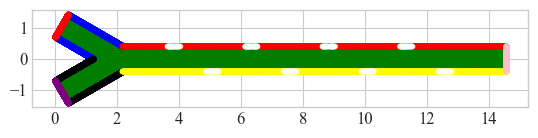

In [17]:
# --- WALL 1 ---
wall_1n = np.array([0.0, 0.0, -B]) + np.array([sp - 2*h, d, 2*B]) * lhs(3, 2*N_b)
wall_1 = []
for i in range(len(wall_1n)):
    a = -co1 * np.abs(wall_1n[i, 2]) + sp - h / np.sin(zav)
    wall_1.append([a, wall_1n[i, 1], wall_1n[i, 2]])
    if len(wall_1) >= N_b:
        break
wall_1 = np.array(wall_1)
print(np.shape(wall_1))

# --- WALL 2 ---
wall_2n = np.array([h*np.sin(zav), 0.0, -B - h*np.cos(zav)]) + np.array([sp - L0 - h*np.sin(zav), d, 2*(B + h*np.cos(zav))]) * lhs(3, 2*N_b)
wall_2 = []
for i in range(len(wall_2n)):
    a = -co1 * np.abs(wall_2n[i, 2]) + sp
    if h*np.sin(zav) <= a <= sp - L0:
        wall_2.append([a, wall_2n[i, 1], wall_2n[i, 2]])
    if len(wall_2) >= N_b:
        break
wall_2 = np.array(wall_2)
print(np.shape(wall_2))

# --- WALL 3 ---
wall_3n = np.array([0.0, 0.0, -L1*np.sin(zav)]) + np.array([x_max, 0.0, 2*L1*np.sin(zav)]) * lhs(3, 3*N_b)
wall_3 = []
for x in wall_3n:
    left_cond = (x[0] < sp - L0 and 
                 -co1*np.abs(x[2]) + sp - h/np.sin(zav) <= x[0] <= -co1*np.abs(x[2]) + sp and 
                 x[0] >= co2*np.abs(x[2]) - D)
    right_cond = (x[0] > sp - L0 and -h/2 < x[2] < h/2)
    if left_cond or right_cond:
        wall_3.append(x)
    if len(wall_3) >= N_b:
        break
wall_3 = np.array(wall_3)

# --- WALL 4 ---
wall_4n = np.array([0.0, d, -L1*np.sin(zav)]) + np.array([x_max, 0.0, 2*L1*np.sin(zav)]) * lhs(3, 3*N_b)
wall_4 = []
for x in wall_4n:
    left_cond = (x[0] < sp - L0 and 
                 -co1*np.abs(x[2]) + sp - h/np.sin(zav) < x[0] < -co1*np.abs(x[2]) + sp and 
                 x[0] >= co2*np.abs(x[2]) - D)
    right_cond = (x[0] > sp - L0 and -h/2 < x[2] < h/2)
    if left_cond or right_cond:
        wall_4.append(x)
    if len(wall_4) >= N_b:
        break
wall_4 = np.array(wall_4)

# --- WALL 5 & 6 ---
wall_5 = np.array([sp - L0, 0.0, h/2]) + np.array([x_max - (sp - L0), d, 0.0]) * lhs(3, N_b)
wall_6 = np.array([sp - L0, 0.0, -h/2]) + np.array([x_max - (sp - L0), d, 0.0]) * lhs(3, N_b)

# --- delfin_wall Function (unchanged) ---
def delfin_wall(wall, n):
    mask = np.ones(len(wall), dtype=bool)
    deleted_points = []
    if n == 6:
        for i in range(len(wall)):
            for j in range(ndf):
                if (sp + L0 + l + j * 2*l < wall[i, 0] < sp + L0 + l + j * 2*l + p1_max * l and 
                    (d - p2_max * d)/2 < wall[i, 1] < (d + p2_max * d)/2):
                    mask[i] = False
                    deleted_points.append(wall[i])
    if n == 5:
        for i in range(len(wall)):
            for j in range(ndf):
                if (sp + L0 + j * 2 * l < wall[i, 0] < sp + L0 + j * 2*l + p1_max * l and 
                    (d - p2_max * d)/2 < wall[i, 1] < (d + p2_max * d)/2):
                    mask[i] = False
                    deleted_points.append(wall[i])
    wall_filtered = wall[mask]
    deleted_points = np.array(deleted_points)
    return wall_filtered, deleted_points

wall_5, walld5 = delfin_wall(wall_5, 5)
wall_6, walld6 = delfin_wall(wall_6, 6)

# --- INLETS & OUTLET ---
inlet_1 = np.array([x_min, y_min, z_min]) + np.array([h*np.sin(zav), d, h/np.cos(zav)]) * lhs(3, N_i)
inlet_2 = np.array([x_min, y_min, z_min]) + np.array([h*np.sin(zav), d, h/np.cos(zav)]) * lhs(3, N_i)
outlet = np.array([L + sp, 0.0, -h/2]) + np.array([0.0, d, h]) * lhs(3, N_i)

for i in range(len(inlet_1)):
    inlet_1[i, 2] = -co1 * (inlet_1[i, 0]) - B
    inlet_2[i, 2] = co1 * (inlet_2[i, 0]) + B

# --- Combine and Categorize ---
wall_st = np.concatenate((wall_1, wall_2), axis=0)
wall_ub = np.array([x for x in wall_st if x[2] >= 0])
wall_lb = np.array([x for x in wall_st if x[2] < 0])

# --- PLOTTING ---
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(wall_3[:,0], wall_3[:,2], marker='.', alpha=0.4 ,color='red')
plt.scatter(wall_4[:,0], wall_4[:,2], marker='.', alpha=0.4 ,color='green')
plt.scatter(wall_ub[:,0], wall_ub[:,2], marker='.', alpha=0.4 ,color='blue')
plt.scatter(wall_lb[:,0], wall_lb[:,2], marker='.', alpha=0.4 ,color='black')
plt.scatter(wall_5[:,0], wall_5[:,2], marker='.', alpha=0.4 ,color='red')
plt.scatter(wall_6[:,0], wall_6[:,2], marker='.', alpha=0.4 ,color='yellow')
plt.scatter(walld5[:,0], walld5[:,2], marker='.', alpha=0.4 ,color='white')
plt.scatter(walld6[:,0], walld6[:,2], marker='.', alpha=0.4 ,color='white')
plt.scatter(inlet_1[:,0], inlet_1[:,2], marker='.', alpha=0.4 ,color='purple')
plt.scatter(inlet_2[:,0], inlet_2[:,2], marker='.', alpha=0.4 ,color='red')
plt.scatter(outlet[:,0], outlet[:,2], marker='.', alpha=0.4 ,color='pink')
plt.show()

Fins shape: (16000, 3)


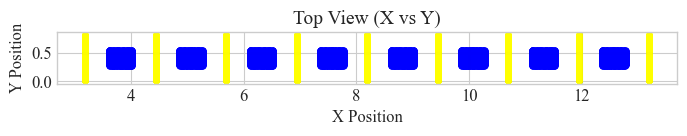

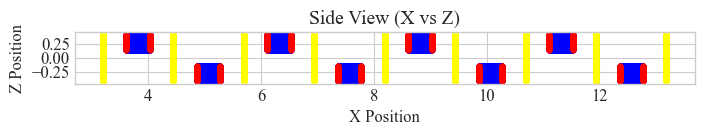

In [18]:
# Generate base points for fins
fin1 = [sp + L0, (d - p2_max * d) / 2, h / 2] + [p1_max * l, p2_max * d, -p3_max * h] * lhs(3, N_f)
fin2 = [sp + L0 + l, (d - p2_max * d) / 2, -h / 2] + [p1_max * l, p2_max * d, p3_max * h] * lhs(3, N_f)

# Initialize fin-specific load points
fin_Jx, fin_Jy, fin_Jz = [], [], []

for i in range(len(fin1)):
    # Randomly select which type of disturbance to apply
    mode = np.random.choice(5)

    if mode == 0:  # Fixed at original X positions
        fin1[i, 0] = L0 + sp
        fin2[i, 0] = L0 + sp + l
        for j in range(ndf):
            fin_Jx.extend([
                fin1[i, :] + [j * l * 2, 0, 0],
                fin2[i, :] + [j * l * 2, 0, 0]
            ])

    elif mode == 1:  # Shifted in X by p1_max * l
        fin1[i, 0] = L0 + sp + p1_max * l
        fin2[i, 0] = L0 + sp + l + p1_max * l
        for j in range(ndf):
            fin_Jx.extend([
                fin1[i, :] + [j * l * 2, 0, 0],
                fin2[i, :] + [j * l * 2, 0, 0]
            ])

    elif mode == 2:  # Lower Y edge
        fin1[i, 1] = (d - p2_max * d) / 2
        fin2[i, 1] = (d - p2_max * d) / 2
        for j in range(ndf):
            fin_Jy.extend([
                fin1[i, :] + [j * l * 2, 0, 0],
                fin2[i, :] + [j * l * 2, 0, 0]
            ])

    elif mode == 3:  # Z top and bottom offset
        fin1[i, 2] = h / 2 - p3_max * h
        fin2[i, 2] = p3_max * h - h / 2
        for j in range(ndf):
            fin_Jz.extend([
                fin1[i, :] + [j * l * 2, 0, 0],
                fin2[i, :] + [j * l * 2, 0, 0]
            ])

    elif mode == 4:  # Upper Y edge
        fin1[i, 1] = (d + p2_max * d) / 2
        fin2[i, 1] = (d + p2_max * d) / 2
        for j in range(ndf):
            fin_Jy.extend([
                fin1[i, :] + [j * l * 2, 0, 0],
                fin2[i, :] + [j * l * 2, 0, 0]
            ])

# Stack all fin points across duplicated structures
fins = np.ones((N_f * ndf * 2, 3))
for i in range(ndf):
    fins[i * N_f:(i + 1) * N_f, :] = fin1 + [i * l * 2, 0, 0]
    fins[(i + ndf) * N_f:(i + ndf + 1) * N_f, :] = fin2 + [i * l * 2, 0, 0]

# Convert to arrays
fin_Jx = np.array(fin_Jx)
fin_Jy = np.array(fin_Jy)
fin_Jz = np.array(fin_Jz)

# Generate evaluation sections (e.g., for loss or prediction tracking)
fsloc = (sp + sp + L0 + L0 + l + p1_max * l) / 2
n = ndf * 2
secs = []
for i in range(-1, n):
    sec = [fsloc + l * i, 0.0, -h / 2] + [0.0, d, h] * lhs(3, N_i)
    secs.append(sec)
secs = np.array(secs)

print("Fins shape:", fins.shape)

# === 2D Visualization: Top View (X-Y) ===
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_aspect('equal')
plt.title('Top View (X vs Y)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.scatter(fins[:, 0], fins[:, 1], marker='.', alpha=0.4, color='blue', label='Fins')
plt.scatter(secs[:, :, 0], secs[:, :, 1], marker='.', alpha=0.4, color='yellow', label='Sections')
# plt.legend()
plt.show()

# === 2D Visualization: Side View (X-Z) ===
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_aspect('equal')
plt.title('Side View (X vs Z)')
plt.xlabel('X Position')
plt.ylabel('Z Position')
plt.scatter(fins[:, 0], fins[:, 2], marker='.', alpha=0.4, color='blue', label='Fins')
plt.scatter(fin_Jx[:, 0], fin_Jx[:, 2], marker='.', alpha=0.4, color='red', label='Jx Load Points')
plt.scatter(secs[:, :, 0], secs[:, :, 2], marker='.', alpha=0.4, color='yellow', label='Sections')
# plt.legend()
plt.show()

In [19]:
# Combine all wall and fin coordinates into a single array
walls = np.concatenate((wall_1, wall_2, wall_3, wall_4, wall_5, wall_6, fins), axis=0)

# Set velocity at all wall/fin locations to zero (no-slip boundary condition)
wall_uvw = np.full_like(walls[:, 0:3], 0)

# Inlet velocity field (u, v, w) setup for inlet_1
inlet_u1 = np.full_like(inlet_1[:, 0:1], umax * np.cos(zav))  # Horizontal component
inlet_v1 = np.zeros_like(inlet_1[:, 1:2])                    # No vertical y-component
inlet_w1 = np.full_like(inlet_1[:, 2:3], umax * np.sin(zav))  # Vertical z-component
inlet_uvw1 = np.concatenate([inlet_u1, inlet_v1, inlet_w1], axis=1)

# Inlet velocity field for inlet_2 (opposite z direction)
inlet_u2 = np.full_like(inlet_2[:, 0:1], umax * np.cos(zav))
inlet_v2 = np.zeros_like(inlet_2[:, 1:2])
inlet_w2 = -np.full_like(inlet_2[:, 2:3], umax * np.sin(zav))  # Opposite z-component
inlet_uvw2 = np.concatenate([inlet_u2, inlet_v2, inlet_w2], axis=1)

# Stack inlet and outlet coordinates together into one array for reference
inout = np.stack((inlet_1, inlet_2, outlet), axis=2)

# Boundary condition enforcement regions for different Jacobian penalties
lb_J = wall_lb
ub_J = wall_ub
wall_Jx = fin_Jx  # x-direction control over fins
wall_Jy = np.concatenate((wall_3, wall_4, fin_Jy), axis=0)
wall_Jz = np.concatenate((wall_5, wall_6, fin_Jz), axis=0)

# Combine all boundary coordinates and corresponding velocity vectors
bc = np.concatenate([inlet_1, inlet_2, walls], axis=0)
bc_uvw = np.concatenate([inlet_uvw1, inlet_uvw2, wall_uvw], axis=0)

# Diagnostics
print('Colocation points:', np.shape(col))
print('Wall points:', np.shape(walls))
print('Inlet/Outlet points:', np.shape(inout))
print('BC velocity vectors:', np.shape(bc_uvw))
print('Section points:', np.shape(secs))


Colocation points: (98532, 3)
Wall points: (60682, 3)
Inlet/Outlet points: (4000, 3, 3)
BC velocity vectors: (68682, 3)
Section points: (9, 4000, 3)


Text(0, 0.5, 'Z')

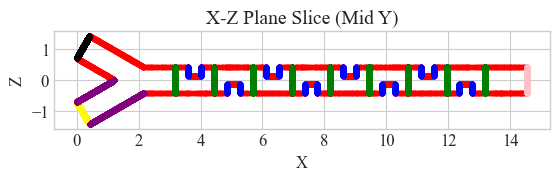

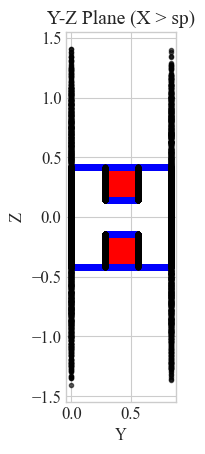

In [22]:
# === 2D Plot (X-Z Plane), filtered by Y (height) ===
fig, ax = plt.subplots()
ax.set_aspect('equal')
a = bc[(bc[:, 1] > d * 0.4) & (bc[:, 1] < d * 0.6)]

ax.scatter(a[:, 0], a[:, 2], marker='.', alpha=0.4, color='red', label='bc mid-slice')
ax.scatter(inlet_1[:, 0], inlet_1[:, 2], marker='.', alpha=0.4, color='yellow', label='inlet 1')
ax.scatter(inlet_2[:, 0], inlet_2[:, 2], marker='.', alpha=0.4, color='black', label='inlet 2')
ax.scatter(outlet[:, 0], outlet[:, 2], marker='.', alpha=0.4, color='pink', label='outlet')
ax.scatter(wall_Jx[:, 0], wall_Jx[:, 2], marker='.', alpha=0.4, color='blue', label='Jx (fins)')
ax.scatter(lb_J[:, 0], lb_J[:, 2], marker='.', alpha=0.4, color='purple', label='LB Jacobian')
ax.scatter(secs[:, :, 0], secs[:, :, 2], marker='.', alpha=0.4, color='green', label='sections')

ax.set_title('X-Z Plane Slice (Mid Y)')
ax.set_xlabel('X')
ax.set_ylabel('Z')
# ax.legend()

# === 2D Plot (Y-Z Plane), filtered by X (after split) ===
fig, ax = plt.subplots()
ax.set_aspect('equal')
b = bc[(bc[:, 0] > sp) & (bc[:, 0] < L)]

ax.scatter(b[:, 1], b[:, 2], marker='.', alpha=0.6, color='red', label='bc after split')
ax.scatter(wall_Jz[:, 1], wall_Jz[:, 2], marker='.', alpha=0.6, color='blue', label='Jz')
ax.scatter(wall_Jy[:, 1], wall_Jy[:, 2], marker='.', alpha=0.6, color='black', label='Jy')

ax.set_title('Y-Z Plane (X > sp)')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
# ax.legend()


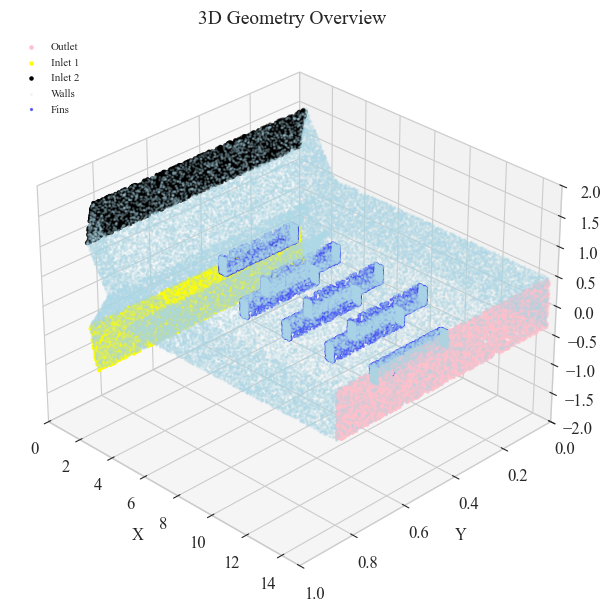

In [43]:
fig = plt.figure(figsize=(6, 18))
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D points
ax.scatter(outlet[:, 0], outlet[:, 1], outlet[:, 2], c='pink', s=5, label='Outlet')
ax.scatter(inlet_1[:, 0], inlet_1[:, 1], inlet_1[:, 2], c='yellow', s=5, label='Inlet 1')
ax.scatter(inlet_2[:, 0], inlet_2[:, 1], inlet_2[:, 2], c='black', s=5, label='Inlet 2')
ax.scatter(walls[:, 0], walls[:, 1], walls[:, 2], c='lightblue', s=1, alpha=0.2, label='Walls')
ax.scatter(fins[:, 0], fins[:, 1], fins[:, 2], c='blue', s=2, alpha=0.5, label='Fins')

# Labeling
ax.set_title('3D Geometry Overview')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(loc='upper left', fontsize=8)
ax.view_init(elev=30, azim=135)

# Equal axis scaling function
def set_axes_equal(ax):
    """Set 3D plot axes to equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max([x_range, y_range, z_range]) / 2.0

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range, x_middle + max_range])
    ax.set_ylim3d([y_middle - max_range, y_middle + max_range])
    ax.set_zlim3d([z_middle - max_range, z_middle + max_range])

# Apply equal scaling
set_axes_equal(ax)

# Set the limits for x, y, and z axes
ax.set_xlim([0, 15])  # x-axis range
ax.set_ylim([0, 1])  # y-axis range
ax.set_zlim([-2, 2])  # z-axis range

# Reverse X-axis
ax.set_xlim(ax.get_xlim()[::-1])  # flips X

plt.tight_layout()
plt.show()
